In [13]:
print("Hello, World!")

Hello, World!


In [14]:
import numpy as np

In [3]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA RTX 2000 Ada Generation Laptop GPU
Using device: cuda


### For Removing duplicate images

In [16]:
import os
from PIL import Image
import hashlib

def image_hash(img_path):
    with Image.open(img_path) as img:
        img = img.convert("RGB")
        return hashlib.md5(img.tobytes()).hexdigest()

def remove_duplicates(folder_path):
    hashes = {}
    removed = 0

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        try:
            img_hash = image_hash(file_path)

            if img_hash in hashes:
                os.remove(file_path)
                removed += 1
            else:
                hashes[img_hash] = file_path

        except Exception as e:
            print(f"Skipping {filename}: {e}")

    print(f"Removed {removed} duplicate images from {folder_path}")

# Run for both folders
remove_duplicates("Datasets/cats")
remove_duplicates("Datasets/dogs")


Skipping Thumbs.db: cannot identify image file 'Datasets/cats\\Thumbs.db'
Removed 0 duplicate images from Datasets/cats
Skipping Thumbs.db: cannot identify image file 'Datasets/dogs\\Thumbs.db'
Removed 0 duplicate images from Datasets/dogs


### Split the dataset into train, test, validation

In [17]:
import os
import shutil
import random

SOURCE_DIR = "Datasets"
TARGET_DIR = "dataset"
SPLIT = (0.7, 0.15, 0.15)  # train, val, test

classes = ["cats", "dogs"]

for cls in classes:
    files = os.listdir(os.path.join(SOURCE_DIR, cls))
    random.shuffle(files)

    n = len(files)
    train_end = int(SPLIT[0] * n)
    val_end = train_end + int(SPLIT[1] * n)

    splits = {
        "train": files[:train_end],
        "val": files[train_end:val_end],
        "test": files[val_end:]
    }

    for split, split_files in splits.items():
        split_dir = os.path.join(TARGET_DIR, split, cls)
        os.makedirs(split_dir, exist_ok=True)

        for f in split_files:
            shutil.copy(
                os.path.join(SOURCE_DIR, cls, f),
                os.path.join(split_dir, f)
            )

print("Dataset split completed.")

Dataset split completed.


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



### Data Preprocessing & Augmentation

In [19]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [20]:
import sys, torch, torchvision, numpy
print(sys.executable)
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("numpy:", numpy.__version__)


c:\Users\faisa\AppData\Local\Programs\Python\Python311\python.exe
torch: 2.2.2+cu121
torchvision: 0.17.2+cu121
numpy: 1.26.4


### Dataset & DataLoader

In [21]:
train_ds = datasets.ImageFolder("dataset/train", transform=train_transform)
val_ds   = datasets.ImageFolder("dataset/val", transform=val_test_transform)
test_ds  = datasets.ImageFolder("dataset/test", transform=val_test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


### Model (Transfer Learning – ResNet18)

In [22]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)


### Loss, Optimizer, Scheduler

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


### Training & Validation

In [24]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
train_accs = []
val_accs = []

EPOCHS = 10

for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # ---- VALIDATION ----
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 0.115 | Train Acc: 0.9543 | Val Loss: 0.056 | Val Acc: 0.9788
Epoch 2/10 | Train Loss: 0.095 | Train Acc: 0.9620 | Val Loss: 0.059 | Val Acc: 0.9777
Epoch 3/10 | Train Loss: 0.094 | Train Acc: 0.9627 | Val Loss: 0.060 | Val Acc: 0.9765
Epoch 4/10 | Train Loss: 0.094 | Train Acc: 0.9623 | Val Loss: 0.053 | Val Acc: 0.9798
Epoch 5/10 | Train Loss: 0.092 | Train Acc: 0.9635 | Val Loss: 0.054 | Val Acc: 0.9794
Epoch 6/10 | Train Loss: 0.091 | Train Acc: 0.9637 | Val Loss: 0.053 | Val Acc: 0.9796
Epoch 7/10 | Train Loss: 0.091 | Train Acc: 0.9635 | Val Loss: 0.056 | Val Acc: 0.9777
Epoch 8/10 | Train Loss: 0.091 | Train Acc: 0.9629 | Val Loss: 0.052 | Val Acc: 0.9802
Epoch 9/10 | Train Loss: 0.096 | Train Acc: 0.9626 | Val Loss: 0.053 | Val Acc: 0.9798
Epoch 10/10 | Train Loss: 0.096 | Train Acc: 0.9623 | Val Loss: 0.057 | Val Acc: 0.9787


### Train vs Val Accuracy

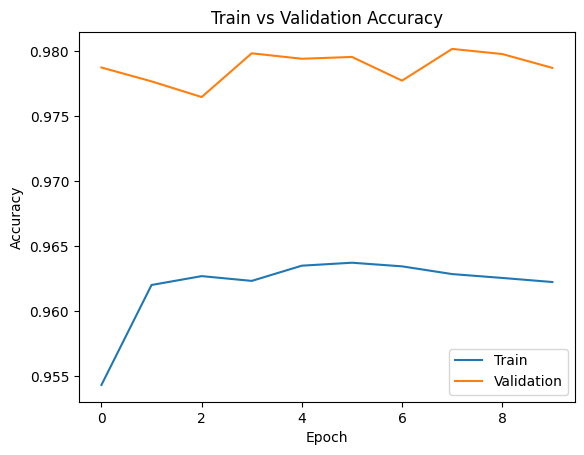

In [25]:
plt.figure()
plt.plot(train_accs)
plt.plot(val_accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

### Train vs Val Loss

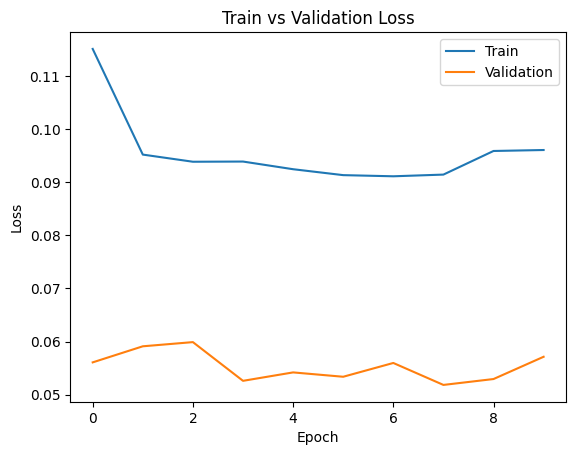

In [26]:
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend(["Train", "Validation"])
plt.show()

### Save Model

In [27]:
torch.save(model.state_dict(), "dog_vs_cat_resnet18_professional.pth")

### Test the model to load the .pth file

In [5]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models

# -------------------------------
# CONFIG
# -------------------------------
TEST_DIR = "dataset/test"   # <-- change if needed
MODEL_PATH = "dog_vs_cat_resnet18_professional.pth"    # <-- your saved model
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# TEST TRANSFORMS (NO AUGMENTATION)
# -------------------------------
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# -------------------------------
# TEST DATASET & LOADER
# -------------------------------
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

class_names = test_dataset.classes
print("Classes:", class_names)

# -------------------------------
# LOAD MODEL
# -------------------------------
# -------------------------------
# LOAD MODEL (MATCH TRAINING)
# -------------------------------
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# IMPORTANT: redefine final layer EXACTLY as training
model.fc = nn.Linear(model.fc.in_features, 2)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()


criterion = nn.CrossEntropyLoss()

# -------------------------------
# TEST LOOP
# -------------------------------
test_loss = 0.0
correct = 0
total = 0

class_correct = [0] * len(class_names)
class_total = [0] * len(class_names)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            class_correct[label] += (preds[i] == labels[i]).item()
            class_total[label] += 1

# -------------------------------
# RESULTS
# -------------------------------
test_loss /= len(test_loader)
test_acc = correct / total

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print("\nClass-wise Accuracy:")
for i, class_name in enumerate(class_names):
    acc = class_correct[i] / class_total[i]
    print(f"{class_name}: {acc:.4f}")


Classes: ['cats', 'dogs']

Test Loss: 0.0587
Test Accuracy: 0.9782

Class-wise Accuracy:
cats: 0.9881
dogs: 0.9683


### Check Manually

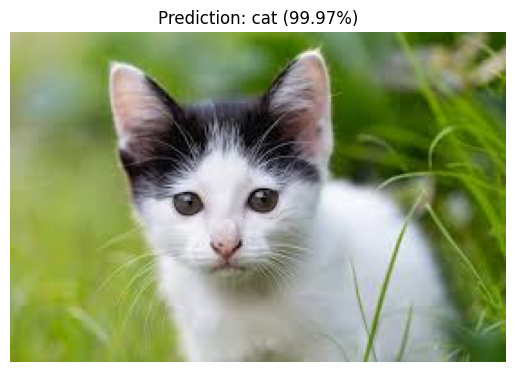

In [8]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------------
# CONFIG
# -------------------------------
IMAGE_PATH = "Catt.jfif"   # <-- put cat or dog image path here
MODEL_PATH = "dog_vs_cat_resnet18_professional.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ["cat", "dog"]   # must match training order

# -------------------------------
# TRANSFORMS (SAME AS VAL/TEST)
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# -------------------------------
# LOAD MODEL
# -------------------------------
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

# -------------------------------
# LOAD IMAGE
# -------------------------------
image = Image.open(IMAGE_PATH).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# -------------------------------
# PREDICTION
# -------------------------------
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)
    confidence, pred = torch.max(probs, 1)

pred_class = class_names[pred.item()]
confidence = confidence.item() * 100

# -------------------------------
# DISPLAY
# -------------------------------
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
plt.show()
